In [3]:
import sys
sys.path.append('../')

import importlib
import matplotlib.pyplot as plt
import glob
import numpy as np
%matplotlib inline
from cycle_gan import img_to_tfrecord
from cycle_gan import models_v2 as models 
# from cycle_gan import models_resnet_based as models
from cycle_gan import train_v1 as train
from cycle_gan import data_gen
from cycle_gan import lr_scheduler
from cycle_gan import utils

import tensorflow as tf
import os 
import cv2


## load data

In [4]:
importlib.reload(data_gen)

photo_dir='/work/data/dog_photo'
monet_dir='/work/data/wikiart'
batch_size=1
shuffle=True
flip=False

train_gen = data_gen.DataGenerator(photo_dir, monet_dir, batch_size, shuffle=True, flip=False)

len(train_gen)

1362

In [5]:
idx = 33
dog, monet = train_gen.__getitem__(idx)
print(dog.shape, monet.shape)


(1, 512, 512, 3) (1, 512, 512, 3)


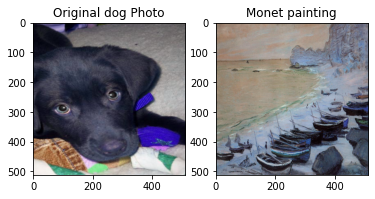

In [6]:
plt.subplot(1, 2, 1)
plt.title("Original dog Photo")
plt.imshow( dog[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet painting")
plt.imshow( monet[0] * 0.5 + 0.5)
plt.show()

## training

In [8]:

monet_generator = models.Generator(img_height=None, img_width=None, name='m_gen', num_residual_blocks=9) # transforms photos to Monet-esque paintings
photo_generator = models.Generator(img_height=None, img_width=None, name='p_gen', num_residual_blocks=9) # transforms Monet paintings to be more like photos

monet_discriminator = models.Discriminator(img_height=None, img_width=None, name='m_disc') # differentiates real Monet paintings and generated Monet paintings
photo_discriminator = models.Discriminator(img_height=None, img_width=None, name='p_disc') # differentiates real photos and generated photos


In [9]:
EPOCHS = 200
lr = 2e-4
num_monet = len(os.listdir(monet_dir))
num_photo = len(os.listdir(photo_dir))

learning_rate_fn = lr_scheduler.CustomSchedule(
    epochs=EPOCHS ,
    num_monet=num_monet,
    num_photo=num_photo,
    initial_lr=lr,
    batch_size=batch_size,
    ending_lr=0,
)


cycle_trainer = train.CycleGanTrainer(monet_generator=monet_generator,
                                      photo_generator=photo_generator,
                                      monet_discriminator=monet_discriminator,
                                      photo_discriminator=photo_discriminator,
                                      lambda_cycle=10,
                                      learning_rate=learning_rate_fn,
                                      checkpoint_dir='/work/logs/renet_cycle_gan_monet_dog_img_pool_ls_gan_loss',
                                      tf_board_dir='/work/logs/cycle_gan_monet_dog_tfboard/gradient_tape/')
        

sample_photo = train_gen[0][0]
cycle_trainer.train(train_data=train_gen, epochs=EPOCHS , sample_photo=sample_photo, evaluate_every=len(train_gen))


total_steps 272400
decay_steps 136200
Model restored from checkpoint at step 262866.


In [10]:
monet_g = models.Generator(img_height=None, img_width=None, name='m_gen', num_residual_blocks=9) # transforms photos to Monet-esque paintings

monet_g.load_weights('2021_04_19_RESNET_monet_dog_gen_dynamic_input_LSGAN_with_lrdecay_to0.h5')


## test data eval

In [11]:
test_dir = '/work/data/dog_photo_test'

test_path = glob.glob(os.path.join(test_dir, '*.jpg'))
test_path[:3]

['/work/data/dog_photo_test/n02102040-English_springer_n02102040_3767.jpg',
 '/work/data/dog_photo_test/n02116738-African_hunting_dog_n02116738_8095.jpg',
 '/work/data/dog_photo_test/n02102318-cocker_spaniel_n02102318_3696.jpg']

In [13]:
def resize(img):
    """
    resize the images to multiples of 256 to work with the 
    unet generator
    """
    h, w,_ = img.shape
    new_h, new_w = (h//256+1)*256, (w//256+1)*256
    if new_h > 512:
        new_h = 512
    if new_w > 512:
        new_w = 512
    resized = cv2.resize(img, (new_w, new_h))

    return resized


def normalize(img):
    return img/ 127.5 - 1

(375, 500, 3) (512, 512, 3)
(329, 250, 3) (512, 256, 3)
(333, 500, 3) (512, 512, 3)
(361, 500, 3) (512, 512, 3)
(375, 500, 3) (512, 512, 3)


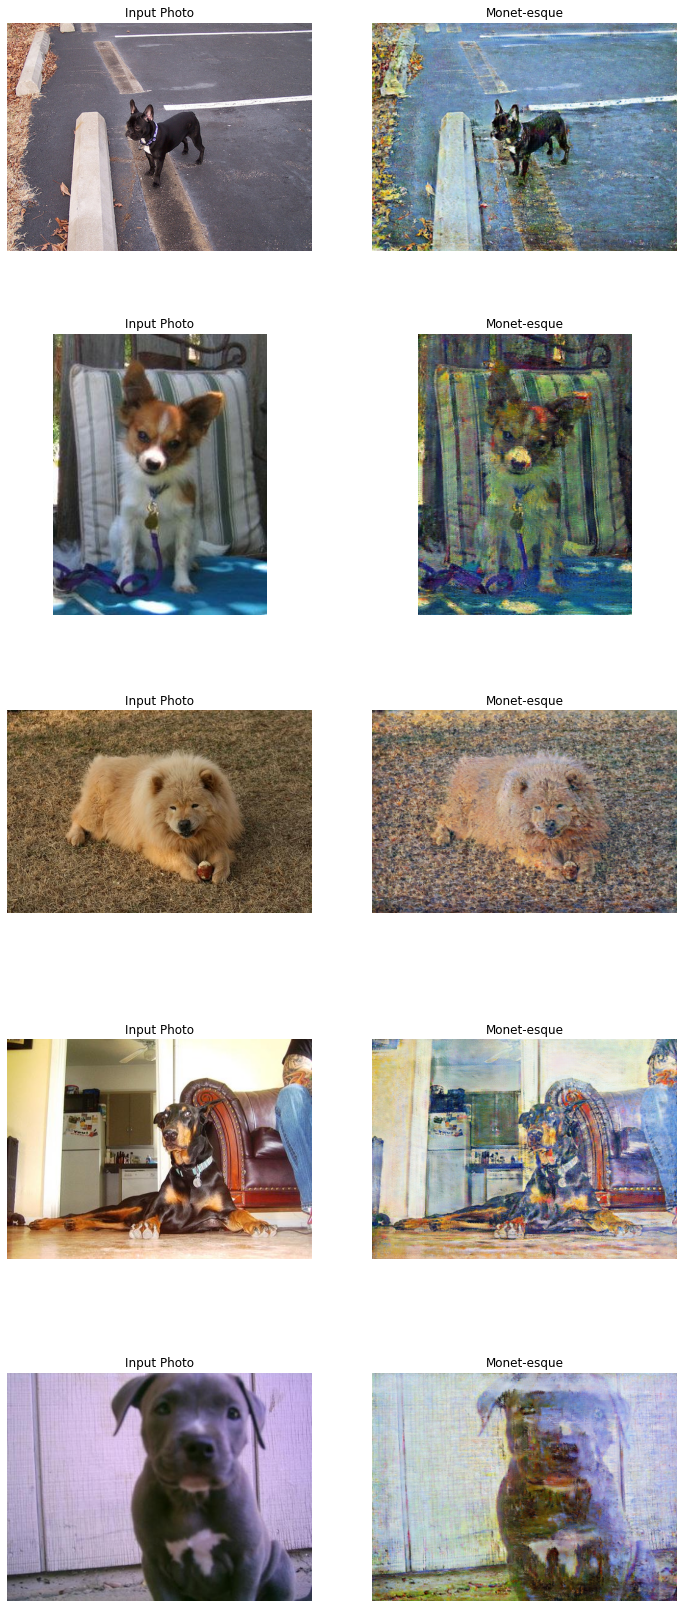

In [15]:

_, ax = plt.subplots(5, 2, figsize=(12, 30))

start = 151
test_path_sub = test_path[start: start+5]
for i in range(len(test_path_sub)):
    path = test_path_sub[i]
    img = cv2.imread(path)
    h, w, _ = img.shape
    
    resized_img = resize(img)
    print(img.shape, resized_img.shape)
    model_input = np.expand_dims(normalize(resized_img), 0)
    
    pred = monet_g(model_input, training=False)[0].numpy()
    pred = (pred * 127.5 + 127.5).astype(np.uint8)
    
    # resize the prediction to the original image dimension
    pred_resized = cv2.resize(pred, (w, h))

    # show images in RGB order
    ax[i, 0].imshow(img[:,:, ::-1])
    ax[i, 1].imshow(pred_resized[:,:,::-1])
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")

    if i == 4:
        break